In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import os

# Ony necessary in MacOSX and Anaconda due to known error with duplicated symbol
# when using OpenMP
# This line can also be avoided installing anaconda's nomkl (conda install nomkl)
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
import egttools as egt

In [5]:
egt.numerical.Random.init()
seed = egt.numerical.Random.seed_

In [6]:
# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

In [7]:
game = egt.numerical.games.NormalFormGame(1, A)

In [8]:
Z = 100
x = np.arange(0, Z+1)/Z

In [9]:
evolver = egt.numerical.PairwiseMoran(Z, game, 1000000)

In [10]:
Z = 100
x = np.arange(0, Z+1)/Z
evolver.pop_size = Z

In [49]:
dist = evolver.stationary_distribution(10, int(1e7), int(1e5), 1.0, 1e-3)

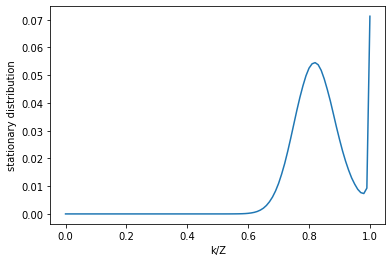

In [50]:
# We need to reverse, since in this case we are starting from the case
# where the number of Haws is 100%, because of how we map states
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, list(reversed(dist)))
ax.set_ylabel('stationary distribution')
ax.set_xlabel('k/Z')
plt.show()

### We can also plot a single run

In [43]:
output = evolver.run(int(1e6), 1, 1e-3, [0, Z])

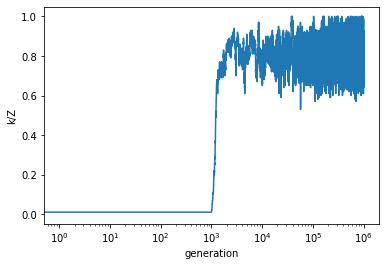

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(output[:, 0]/Z)
ax.set_ylabel('k/Z')
ax.set_xlabel('generation')
ax.set_xscale('log')
plt.show()